# This is the notebook for xgboost based classification for Parkinson data


In [1]:
# requirements
import os
import sys
sys.path.insert(0,'..') # to add parent directory
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from utils.data_loader import PatientsRawData
from utils.preprocessing import preprocess_signal
from utils.augment_data import get_augmentation_indexes, augment_data
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

First let's load the data as they are. Display some data statistics.

In [2]:
data = PatientsRawData('../../data/Исходные файлы/')
data.load_data()
print(f' Data labels: {data.Y} for the total of {len(data.X)} data samples coming from patients: {data.patient}')
print('Explore a random data sample: ')
N = random.randint(0,len(data.X))
data.X[N].head()

 Data labels: ['Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right'] for the total of 41 data samples coming from patients: ['аста0101.txt', 'дюки0102.txt', 'керш0103.txt', 'лега0104.txt', 'сидо0105.txt', 'фрол0106.txt', 'хвал0107.txt', 'черк0108.txt', 'даке0101.txt', 'ершо0102.txt', 'кудр0103.txt', 'купр0104.txt', 'куту0105.txt', 'лити0106.txt', 'луче0107.txt', 'макс0108.txt', 'миро0109.txt', 'молю01010.txt', 'муха01011.txt', 'соко01012.txt', 'тихо01013.txt', 'ерми0101.txt', 'кова0102.txt', 'колг0103.txt', 'медв0104.txt', 'наза0105.txt', 'погр0106.txt', 'савв0107.txt', 'сави0108.txt', 'шелу0109.txt', 'бело0101.txt', 'гава0102.txt', 'голу0103.txt', 'грек0104.txt', 'губа0105.txt', 'павл0106.txt', 'пана0107.tx

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T3,T4,T5,T6,CZ,EMG1,EMG2,EMG3,EMG4
0,-8,-21,-15,17,-32,17,-14,-6,-69,-17,...,-3,-61,20,-42,2,-11,-47,-52,11,33
1,-6,-27,2,25,-17,30,9,8,-54,-5,...,12,-36,31,-26,18,-13,-63,29,6,5
2,-27,-38,-13,22,-37,33,0,8,-80,-9,...,7,-52,41,-43,24,-15,14,54,18,-25
3,-20,-40,-17,26,-44,32,-2,-6,-97,-20,...,8,-59,79,-56,3,-21,-21,4,7,-126
4,-5,-38,-12,32,-44,38,2,-8,-102,-22,...,7,-60,70,-56,10,-22,-12,28,10,-101


## Pre-processing
Then select only the EMG data and apply pre-processing to the data.

In [3]:
# let's now clean the data to only have EMG data
data.get_emg_data()
data.X[N].head()

,EMG1,EMG2,EMG3,EMG4
0,-47,-52,11,33
1,-63,29,6,5
2,14,54,18,-25
3,-21,4,7,-126
4,-12,28,10,-101


In [4]:
data.X[N]

,EMG1,EMG2,EMG3,EMG4
0,-47,-52,11,33
1,-63,29,6,5
2,14,54,18,-25
3,-21,4,7,-126
4,-12,28,10,-101
...,...,...,...,...
68155,-37,-39,4,34
68156,-20,-8,-4,13
68157,-9,40,4,-13
68158,22,32,-2,102


In [5]:
# convert data to numpy
min_sequence = 10000000000
try:
    data.convert_to_numpy()
except:
    print('already converted, skipping!')
#preprocess all the data
for i in range(len(data.X)):
    one_patient_emg = data.X[i]
    for j, emg_channel in enumerate(one_patient_emg):
        if len(emg_channel)<min_sequence:
            min_sequence = len(emg_channel) 
        processed_signal =  preprocess_signal(emg_channel,  SamplingRate=500,  LF=60, HF=240, frequences_to_filter = [50, 100, 150, 200 ], order_butter=4, save_plot=False) 
        data.X[i][j]=processed_signal # save to the previous unprocessed signal
    print(f'Pre-processed patient {i}')    

Pre-processed patient 0
Pre-processed patient 1
Pre-processed patient 2
Pre-processed patient 3
Pre-processed patient 4
Pre-processed patient 5
Pre-processed patient 6
Pre-processed patient 7
Pre-processed patient 8
Pre-processed patient 9
Pre-processed patient 10
Pre-processed patient 11
Pre-processed patient 12
Pre-processed patient 13
Pre-processed patient 14
Pre-processed patient 15
Pre-processed patient 16
Pre-processed patient 17
Pre-processed patient 18
Pre-processed patient 19
Pre-processed patient 20
Pre-processed patient 21
Pre-processed patient 22
Pre-processed patient 23
Pre-processed patient 24
Pre-processed patient 25
Pre-processed patient 26
Pre-processed patient 27
Pre-processed patient 28
Pre-processed patient 29
Pre-processed patient 30
Pre-processed patient 31
Pre-processed patient 32
Pre-processed patient 33
Pre-processed patient 34
Pre-processed patient 35
Pre-processed patient 36
Pre-processed patient 37
Pre-processed patient 38
Pre-processed patient 39
Pre-proces

At this point, we have the processed data. The only problem is that they are not of the same length, so we need to select the smallest lenght of a sequence and cut all the sequences which are longer than this one.

In [6]:
# save the pre-processed data into a csv
from csv import writer
with open('data.csv', 'a') as f_object:
    writer_object = writer(f_object)  
    for i in range(len(data.X)):
        patient = data.X[i]
        for j in range(len(patient[0])):
                data_list = [i, patient[0][j],patient[1][j],patient[2][j],patient[3][j], data.Y[i]]
                writer_object.writerow(data_list)
  
    #Close the file object
f_object.close()

In [7]:
len(patient[0])

73800

In [65]:
# min_sequence for the data is 65190, so let's cut everything to this lenght
#preprocess all the data
for i in range(len(data.X)):
    data.X[i]=data.X[i][:,:65190] # save to the previous unprocessed signal

## Dividing into training and validation set
The goal of this operation is to have training and validation data sets, which consist from different patients.
In the same moment, we want the number of pathologies be the same in training and validation sets.
The function is already implemented in the dataset class, so here we just apply it and verify the result.
The number of val patients is very small, we will leave out just 10% of the data.

In [ ]:
# TODO Make the train/test 0.5 0.5 
# divide RP and LP
# CNN Morlet Wavelet output -> few shot learning
# Trees -> SVM, Regression, Explainable 
# Characteristics from signal
# Small subsets: proove
# small subsets augmentation 
# idea: quality of the tree by inserting random values
# augemnation : split signal into random parts 
# use L, R separately as different patients
# try different ways : ill / healthy subsets for all three cases
# augmentation -> evaluate this process

In [6]:
data.get_train_val_split(test_size=0.5, stratified=True)

The statistics in the resulting dataset are the following:

In [7]:
print(f'Train:  {data.y_train}')
print(f'Test: {data.y_test}')

Train:  ['Left', 'ET', 'Left', 'ET', 'Right', 'Control', 'Left', 'Right', 'ET', 'Right', 'ET', 'Left', 'Left', 'Control', 'ET', 'ET', 'Control', 'ET', 'Control', 'Right', 'Right', 'Right', 'Right', 'ET', 'ET', 'Right', 'ET', 'Right', 'Left', 'Control', 'Control', 'Control', 'ET', 'Left', 'Left', 'Right']
Test: ['ET', 'Left', 'Control', 'ET', 'Right']


Now we can perform the data augmentation for the training data. Test data will be used for test only.

## Data augmentation
Data augmentation is performed based on patients category such that:

Control group can be augmentented withing the control group to get the total number of data:

perm = $n_{controlgroup}^{2}$

ET group can be augmented withing the ET group to get the total number of data:

perm = $n_{ET}^{2}$

Finally, Parkinson group for Left and Right Parkinson can be augmented within each other.

perm = $(n_{Left}+n_{Right})^{2}$

In [8]:
# patients ET, let't get them from training data
et_patients = []
for i, y in enumerate(data.y_train):
    if y== 'ET':
        et_patients.append(data.X_train[i])
assert len(et_patients) == data.y_train.count('ET')
# now let's augment these patients
ind = get_augmentation_indexes(et_patients)
et_augmented = augment_data(et_patients, ind)
print(f'Totally, we have {len(et_augmented)} ET patients using the augmentation')

In [10]:
# let's do the same for the control group
control_patients = []
for i, y in enumerate(data.y_train):
    if y== 'Control':
        control_patients.append(data.X_train[i])
assert len(control_patients) == data.y_train.count('Control')
# now let's augment these patients
ind = get_augmentation_indexes(control_patients)
control_augmented = augment_data(control_patients, ind)
print(f'Totally, we have {len(control_augmented)} Control  patients using the augmentation')

In [12]:
# Finally, let's proceed to the Parkinson group
# First left parkinson
parkinson_left_patients = []
for i, y in enumerate(data.y_train):
    if y == 'Left':
        parkinson_left_patients.append(data.X_train[i])
assert len(parkinson_left_patients) == data.y_train.count('Left')
# now let's augment these patients
ind = get_augmentation_indexes(parkinson_left_patients)
parkinson_left_augmented = augment_data(parkinson_left_patients, ind)
print(f'Totally, we have {len(parkinson_left_augmented)} Parkinson patients using the augmentation')
# then right parkinson
parkinson_right_patients = []
for i, y in enumerate(data.y_train):
    if y == 'Right':
        parkinson_right_patients.append(data.X_train[i])
assert len(parkinson_rigt_patients) == data.y_train.count('Right')
# now let's augment these patients
ind = get_augmentation_indexes(parkinson_right_patients)
parkinson_rigt_augmented = augment_data(parkinson_right_patients, ind)
print(f'Totally, we have {len(parkinson_right_augmented)} Parkinson patients using the augmentation')

## XGBOOST
Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

Extreme Gradient Boosting, or XGBoost for short is an efficient open-source implementation of the gradient boosting algorithm. As such, XGBoost is an algorithm, an open-source project, and a Python library.

It was initially developed by Tianqi Chen and was described by Chen and Carlos Guestrin in their 2016 paper titled “XGBoost: A Scalable Tree Boosting System.”

[This](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/) tutorial was used to apply the XGBoost.

In [2]:
from xgboost import XGBClassifier
import pandas as pd

Let's prepare the dataset for the XGboost tree. 
Unfortunately, the algorithm  expects the features in the 1D shape. 
Therefore, first, the data are transformed into 1D vectors.
Simple concatination was chosen.

In [17]:
data_raw = pd.read_csv("../CNN/data_cnn.csv",header = None)
data_np = data_raw.to_numpy()
y = data_np[:,0].astype('int')
X = data_np[:,1:]

In [18]:
print(X.shape, y.shape)

(40, 24) (40,)


In [3]:
# test classification dataset
# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
# define the model
model = XGBClassifier(n_estimators=10)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

NameError: name 'X' is not defined

The result looks not bad on the training data, to verify it in more details, we can change n_splits and n_repeats parametrs (but it takes long time to compute). Let's now check the obtained model will classify the patients which we left 'aside' previosly.

In [14]:
# explore xgboost number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y
 
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [10, 50, 100, 500, 1000, 5000]
    for n in trees:
        models[str(n)] = XGBClassifier(n_estimators=n)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X,y):
    cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 


/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


>10 0.350 (0.229)


/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


>50 0.358 (0.211)


/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


>100 0.358 (0.211)


/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


>500 0.375 (0.230)


/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


>1000 0.367 (0.230)


/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/mnt/c/Users/KHOKHLOVAM/Documents/venvs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


>5000 0.375 (0.230)


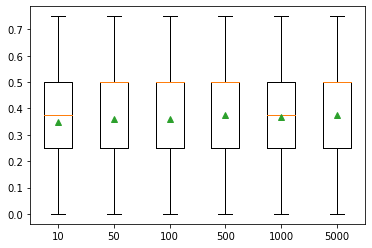

In [25]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

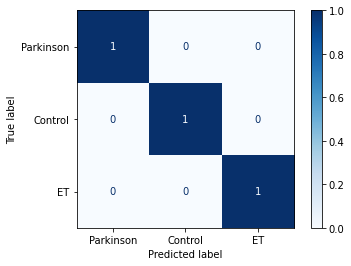

In [29]:
# Predict on the same data and make a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X,
    y,
    display_labels=['Parkinson','Control','ET'],
    cmap=plt.cm.Blues,
    normalize='true',
)

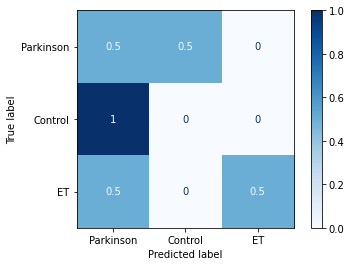

In [30]:
cm = confusion_matrix(y_test, yhat)
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test, y_test,
    display_labels=['Parkinson','Control','ET'],
    cmap=plt.cm.Blues,
    normalize='true',
)

It looks like the final accuracy on our (very small) test set is not very good.
It will be necessary to redo the dataset creation multiple times to confirm this number. 
The accuracy of this model is 0.6.

In [78]:
sum(y_test == yhat)/(len(y_test))

0.6

## Tuning of the algorihm
### Explore Number of Trees
An important hyperparameter for the XGBoost ensemble algorithm is the number of decision trees used in the ensemble.

In [15]:
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000]
	for n in trees:
		models[str(n)] = XGBClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [74]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.977 (0.008)
>50 0.974 (0.005)
>100 0.974 (0.005)
>500 0.974 (0.005)


KeyboardInterrupt: 

# Experiment with XGBoost trees

To verify that our classification works (or doesn't work), let's repeat the experiment multiple times and calculate the average results.
                                         

In [110]:
n = 100 #repeat experiment n times
scores = []
average_conf = np.zeros((4,4))
for i in range(1,n): 
    data.get_train_val_split(test_size=0.4, stratified=True)
    print(f'Train:  {data.y_train}')
    print(f'Test: {data.y_test}')
    # now get all the data and augment them
    # patients ET, let't get them from training data
    et_patients = []
    for i, y in enumerate(data.y_train):
        if y == 'ET':
            et_patients.append(data.X_train[i])
    assert len(et_patients) == data.y_train.count('ET')
    # now let's augment these patients
    ind = get_augmentation_indexes(et_patients)
    et_augmented = augment_data(et_patients, ind)
    print(f'Totally, we have {len(et_augmented)} ET patients using the augmentation')
    # let's do the same for the control group
    control_patients = []
    for i, y in enumerate(data.y_train):
        if y== 'Control':
            control_patients.append(data.X_train[i])
    assert len(control_patients) == data.y_train.count('Control')
    # now let's augment these patients
    ind = get_augmentation_indexes(control_patients)
    control_augmented = augment_data(control_patients, ind)
    print(f'Totally, we have {len(control_augmented)} Control  patients using the augmentation')
    # Finally, let's proceed to the Parkinson group
    # First left parkinson
    parkinson_left_patients = []
    for i, y in enumerate(data.y_train):
        if y == 'Left':
            parkinson_left_patients.append(data.X_train[i])
    assert len(parkinson_left_patients) == data.y_train.count('Left')
    # now let's augment these patients
    ind = get_augmentation_indexes(parkinson_left_patients)
    parkinson_left_augmented = augment_data(parkinson_left_patients, ind)
    print(f'Totally, we have {len(parkinson_left_augmented)} Parkinson patients using the augmentation')
    # then right parkinson
    parkinson_right_patients = []
    for i, y in enumerate(data.y_train):
        if y == 'Right':
            parkinson_right_patients.append(data.X_train[i])
    assert len(parkinson_right_patients) == data.y_train.count('Right')
    # now let's augment these patients
    ind = get_augmentation_indexes(parkinson_right_patients)
    parkinson_right_augmented = augment_data(parkinson_right_patients, ind)
    print(f'Totally, we have {len(parkinson_right_augmented)} Parkinson patients using the augmentation')
    # fuse back the data for training
    total_patients = len(parkinson_left_augmented)+len(parkinson_right_augmented)+len(control_augmented)+len(et_augmented)
    X = np.zeros((total_patients, 65190*4)) # whole dataset
    for i, patient in enumerate(parkinson_left_augmented + parkinson_right_augmented + control_augmented + et_augmented):
        patient_1d = patient.ravel()
        X[i,:] = patient_1d
    y =  np.array(len(parkinson_left_augmented)*[0] + len(parkinson_right_augmented)*[1] +len(control_augmented)*[2]+len(et_augmented)*[3])
    model = XGBClassifier(n_estimators=10)
    model.fit(X, y)
    ## prepare all the test data
    # prepare the testing data same as the train data
    y_test =  np.zeros(len(data.y_test))
    X_test = np.zeros((len(data.y_test), 65190*4))
    for i, _ in enumerate(data.X_test):
        patient_1d = data.X_test[i].ravel()
        X_test[i,:] = patient_1d
        if data.y_test[i] == 'Control':
            y_test[i]=2
        elif data.y_test[i] == 'ET':
            y_test[i]=3
        elif data.y_test[i] == 'Left':
            y_test[i]=0
        else:
            y_test[i]=1
    # check model
    yhat = model.predict(X_test)
    cm = confusion_matrix(y_test, yhat,normalize='true')
    scores.append(sum(y_test == yhat)/(len(y_test)))

    average_conf += cm

Train:  ['ET', 'ET', 'ET', 'Left', 'Right', 'Right', 'ET', 'Control', 'Right', 'ET', 'ET', 'Control', 'Left', 'Right', 'Control', 'ET', 'Left', 'ET', 'Left', 'Control', 'Left', 'Right', 'Control', 'Right']
Test: ['ET', 'Right', 'ET', 'Right', 'Left', 'Right', 'ET', 'Control', 'Control', 'Left', 'Right', 'ET', 'Left', 'Right', 'Left', 'Control', 'ET']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Control', 'Right', 'ET', 'ET', 'Control', 'ET', 'Right', 'Control', 'ET', 'Left', 'Control', 'Right', 'ET', 'Right', 'ET', 'ET', 'ET', 'Left', 'Right', 'Left', 'Right', 'Control', 'Left', 'Left']
Test: ['Right', 'ET', 'Control', 'Right', 'Right', 'Right', 'Left', 'ET', 'Control', 'ET', 'Right', 'ET', 'Left', 'Left', 'ET', 'Control', 'Left']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Right', 'ET', 'Left', 'ET', 'Left', 'Right', 'Left', 'ET', 'Control', 'Right', 'ET', 'Left', 'Right', 'ET', 'Control', 'Control', 'Left', 'ET', 'Control', 'ET', 'ET', 'Right', 'Right', 'Control']
Test: ['ET', 'ET', 'Control', 'ET', 'ET', 'Right', 'Left', 'Right', 'Right', 'Right', 'Control', 'Right', 'Left', 'Control', 'ET', 'Left', 'Left']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Control', 'Control', 'Right', 'Left', 'Left', 'Left', 'ET', 'ET', 'Left', 'Control', 'Control', 'Right', 'Right', 'Right', 'ET', 'ET', 'Right', 'Left', 'ET', 'Control', 'ET', 'ET', 'ET', 'Right']
Test: ['Right', 'Left', 'ET', 'Right', 'ET', 'Control', 'Left', 'Right', 'ET', 'Left', 'Right', 'Control', 'ET', 'Right', 'Left', 'ET', 'Control']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['ET', 'Left', 'Right', 'ET', 'Right', 'Left', 'Left', 'Control', 'ET', 'Right', 'Right', 'ET', 'Control', 'Right', 'Control', 'ET', 'Right', 'Control', 'Left', 'ET', 'Control', 'ET', 'ET', 'Left']
Test: ['Control', 'Right', 'Control', 'ET', 'Right', 'Right', 'Right', 'ET', 'Right', 'Control', 'ET', 'Left', 'Left', 'Left', 'ET', 'Left', 'ET']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['ET', 'Left', 'Right', 'Left', 'Control', 'Control', 'ET', 'ET', 'ET', 'ET', 'Right', 'Left', 'Control', 'ET', 'Right', 'Right', 'Right', 'Control', 'ET', 'Left', 'ET', 'Right', 'Control', 'Left']
Test: ['Left', 'ET', 'Left', 'ET', 'Control', 'Right', 'ET', 'Control', 'Control', 'Left', 'Right', 'Right', 'ET', 'Right', 'Left', 'ET', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['ET', 'Left', 'Left', 'Right', 'ET', 'ET', 'Control', 'Right', 'Control', 'Control', 'ET', 'ET', 'ET', 'Right', 'Left', 'Right', 'Control', 'ET', 'Right', 'Control', 'ET', 'Right', 'Left', 'Left']
Test: ['Control', 'Left', 'ET', 'Left', 'ET', 'ET', 'Right', 'Left', 'Right', 'Control', 'ET', 'ET', 'Right', 'Control', 'Right', 'Left', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['ET', 'Control', 'Left', 'ET', 'Right', 'Left', 'Left', 'Right', 'Right', 'ET', 'Control', 'Right', 'ET', 'ET', 'Left', 'Control', 'Right', 'ET', 'Control', 'Right', 'ET', 'ET', 'Left', 'Control']
Test: ['Right', 'Control', 'Left', 'Right', 'Control', 'ET', 'Right', 'ET', 'Left', 'ET', 'ET', 'Left', 'Control', 'Right', 'Right', 'ET', 'Left']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Right', 'Control', 'ET', 'ET', 'Control', 'Right', 'Control', 'Right', 'Left', 'Right', 'ET', 'ET', 'Control', 'Right', 'Left', 'Left', 'ET', 'Left', 'ET', 'Right', 'Left', 'ET', 'Control', 'ET']
Test: ['Left', 'Left', 'Left', 'Control', 'ET', 'Control', 'Control', 'ET', 'Left', 'ET', 'Right', 'ET', 'Right', 'Right', 'Right', 'Right', 'ET']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Left', 'ET', 'Right', 'ET', 'Left', 'Control', 'ET', 'Left', 'Right', 'Left', 'Control', 'ET', 'Right', 'ET', 'Right', 'Control', 'ET', 'Left', 'Control', 'Right', 'ET', 'Right', 'Control', 'ET']
Test: ['ET', 'Control', 'Right', 'Left', 'Right', 'ET', 'Right', 'ET', 'Left', 'ET', 'Left', 'Left', 'Right', 'Control', 'Right', 'Control', 'ET']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Right', 'Control', 'Left', 'Right', 'Left', 'Right', 'ET', 'ET', 'Control', 'ET', 'Left', 'Control', 'Right', 'ET', 'Right', 'Control', 'ET', 'Left', 'ET', 'ET', 'Left', 'Right', 'ET', 'Control']
Test: ['Left', 'ET', 'ET', 'Right', 'Right', 'Left', 'Control', 'Left', 'Right', 'Right', 'Left', 'ET', 'Right', 'ET', 'Control', 'ET', 'Control']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['ET', 'ET', 'Control', 'Right', 'Left', 'Right', 'ET', 'Left', 'ET', 'Control', 'Right', 'Control', 'Left', 'Right', 'Right', 'Left', 'Control', 'Right', 'ET', 'ET', 'Left', 'ET', 'ET', 'Control']
Test: ['Left', 'Control', 'ET', 'ET', 'ET', 'Left', 'Left', 'Left', 'ET', 'Control', 'Right', 'Right', 'Right', 'Control', 'Right', 'ET', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Left', 'Control', 'Right', 'Control', 'ET', 'Control', 'Left', 'ET', 'Control', 'Right', 'Control', 'Right', 'ET', 'Right', 'ET', 'ET', 'ET', 'Left', 'ET', 'ET', 'Left', 'Left', 'Right', 'Right']
Test: ['Left', 'Left', 'Control', 'ET', 'ET', 'Left', 'Right', 'Left', 'Right', 'ET', 'Control', 'Right', 'Control', 'Right', 'ET', 'ET', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['ET', 'ET', 'Left', 'Right', 'Left', 'Control', 'Right', 'Left', 'ET', 'Right', 'Control', 'Right', 'ET', 'Control', 'Right', 'Left', 'Control', 'ET', 'ET', 'ET', 'ET', 'Right', 'Left', 'Control']
Test: ['Control', 'ET', 'ET', 'Left', 'Right', 'Left', 'Left', 'ET', 'Left', 'Right', 'Right', 'Control', 'ET', 'Control', 'Right', 'ET', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Left', 'ET', 'Left', 'ET', 'ET', 'Right', 'Left', 'ET', 'Left', 'ET', 'ET', 'Control', 'Right', 'Control', 'Control', 'Control', 'Right', 'Control', 'ET', 'Right', 'Right', 'ET', 'Left', 'Right']
Test: ['Right', 'Right', 'ET', 'Control', 'ET', 'Control', 'Left', 'ET', 'Left', 'ET', 'Control', 'Right', 'Right', 'Left', 'Left', 'ET', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Right', 'Left', 'Right', 'ET', 'Right', 'Control', 'ET', 'Control', 'Control', 'ET', 'ET', 'Control', 'Right', 'Left', 'Left', 'ET', 'ET', 'Left', 'ET', 'Right', 'ET', 'Control', 'Left', 'Right']
Test: ['ET', 'Control', 'Left', 'ET', 'Right', 'Control', 'Control', 'Right', 'ET', 'Right', 'Right', 'ET', 'Left', 'Right', 'ET', 'Left', 'Left']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['ET', 'ET', 'ET', 'ET', 'Right', 'Control', 'ET', 'Right', 'Right', 'Left', 'Left', 'Control', 'Right', 'ET', 'Right', 'Left', 'Left', 'Control', 'Right', 'ET', 'Control', 'ET', 'Control', 'Left']
Test: ['ET', 'Control', 'Right', 'Left', 'Control', 'ET', 'ET', 'Left', 'ET', 'Right', 'ET', 'Control', 'Right', 'Right', 'Left', 'Right', 'Left']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Control', 'Right', 'Left', 'Right', 'ET', 'Left', 'ET', 'Right', 'Control', 'Left', 'ET', 'Control', 'Control', 'ET', 'ET', 'Left', 'Right', 'Right', 'ET', 'ET', 'Left', 'ET', 'Control', 'Right']
Test: ['ET', 'Control', 'Control', 'ET', 'ET', 'Right', 'ET', 'Left', 'Right', 'Left', 'Right', 'Control', 'Left', 'ET', 'Right', 'Left', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Right', 'ET', 'Right', 'Left', 'Control', 'Control', 'ET', 'Control', 'ET', 'Control', 'Left', 'Right', 'ET', 'Control', 'Right', 'Right', 'ET', 'Left', 'ET', 'ET', 'Left', 'Left', 'Right', 'ET']
Test: ['Right', 'Left', 'Control', 'Control', 'Left', 'Right', 'Left', 'ET', 'ET', 'Control', 'ET', 'ET', 'Right', 'Right', 'ET', 'Right', 'Left']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Control', 'Control', 'Control', 'Right', 'Left', 'Right', 'ET', 'ET', 'ET', 'ET', 'Right', 'ET', 'ET', 'Right', 'ET', 'ET', 'Right', 'Right', 'Left', 'Left', 'Control', 'Control', 'Left', 'Left']
Test: ['Left', 'Right', 'ET', 'ET', 'Left', 'Control', 'Control', 'Right', 'Right', 'Right', 'Right', 'Left', 'ET', 'ET', 'ET', 'Left', 'Control']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Right', 'ET', 'Right', 'Right', 'Left', 'ET', 'ET', 'Right', 'Right', 'ET', 'ET', 'Left', 'ET', 'Control', 'Left', 'Left', 'ET', 'Control', 'Left', 'Right', 'Control', 'Control', 'ET', 'Control']
Test: ['Left', 'Control', 'Right', 'ET', 'Right', 'Right', 'Left', 'Left', 'ET', 'Right', 'Left', 'ET', 'Control', 'ET', 'Control', 'ET', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Control', 'Left', 'Control', 'Right', 'ET', 'Right', 'ET', 'ET', 'Right', 'ET', 'Left', 'Left', 'Left', 'Control', 'Right', 'Right', 'Right', 'Left', 'Control', 'ET', 'Control', 'ET', 'ET', 'ET']
Test: ['Left', 'Control', 'Right', 'Control', 'Right', 'Control', 'ET', 'Left', 'Right', 'ET', 'Right', 'ET', 'ET', 'Left', 'Left', 'Right', 'ET']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Control', 'ET', 'Right', 'Left', 'Control', 'Right', 'Right', 'ET', 'Right', 'Left', 'Left', 'Left', 'Control', 'ET', 'Control', 'ET', 'Control', 'ET', 'Right', 'ET', 'Left', 'ET', 'Right', 'ET']
Test: ['Left', 'Control', 'ET', 'Control', 'Left', 'ET', 'Control', 'ET', 'Right', 'Left', 'Left', 'ET', 'ET', 'Right', 'Right', 'Right', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Control', 'ET', 'ET', 'Right', 'ET', 'Right', 'ET', 'Control', 'Control', 'Control', 'Left', 'Right', 'Right', 'Right', 'Left', 'ET', 'Control', 'ET', 'Right', 'Left', 'Left', 'ET', 'Left', 'ET']
Test: ['Control', 'ET', 'Left', 'Right', 'Right', 'ET', 'Left', 'Control', 'ET', 'Right', 'ET', 'ET', 'Right', 'Left', 'Left', 'Control', 'Right']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Train:  ['Left', 'Left', 'Control', 'ET', 'ET', 'Left', 'Control', 'Right', 'ET', 'Right', 'Control', 'Right', 'Control', 'ET', 'Right', 'Right', 'ET', 'Right', 'ET', 'ET', 'Control', 'Left', 'ET', 'Left']
Test: ['Left', 'ET', 'Left', 'Right', 'Control', 'Control', 'ET', 'Right', 'ET', 'Right', 'Left', 'Control', 'Right', 'Left', 'Right', 'ET', 'ET']
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190)
(4, 65190

Resulting accuracy and averaged confusion matrice are:

In [111]:
print(f'Mean accuracy: {mean(scores)}, std {np.std(scores)}')

Mean accuracy: 0.2953060011883541, std 0.09384236255448429


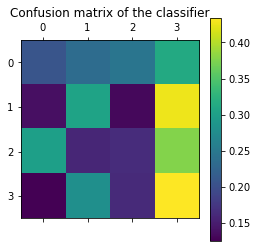

In [112]:
plt.matshow(average_conf/len(scores))
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.show()

In [113]:
import pandas as pd
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]
df = cm2df(average_conf/len(scores), ['Left', 'Right', 'Control','ET'])
print(df)

             Left     Right   Control        ET
Left     0.207071  0.234848  0.244949  0.313131
Right    0.137374  0.305051  0.131313  0.426263
Control  0.299663  0.158249  0.164983  0.377104
ET       0.125253  0.278788  0.161616  0.434343


/tmp/ipykernel_68/2320467682.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
/tmp/ipykernel_68/2320467682.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
/tmp/ipykernel_68/2320467682.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
/tmp/ipykernel_68/2320467682.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))


Overall, the accuracy is very low.
It demonstrates that the XGBoost Trees cannot classify the data.

## Classification 1-to-1: ill vs healthy individuals
Previous strategy did not work, the classification results are close to the random ones.
Therefore, we decided to try to use the method for a simpler task: to classify patient with an ilness vs healthy individual,
and also the data of patients with a diagnosis across different diagnoses.
Let's start by the patients with ET and a control group.

### ET Patients vs Control

In [8]:
n = 100 #repeat experiment n times
scores = []
average_conf = np.zeros((2,2))
for i in range(1,n):
    data.get_train_val_split(test_size=0.4, stratified=True)
    print(f'Train:  {data.y_train}')
    print(f'Test: {data.y_test}')
    # now get all the data and augment them
    # patients ET, let't get them from training data
    et_patients = []
    for i, y in enumerate(data.y_train):
        if y == 'ET':
            et_patients.append(data.X_train[i])
    assert len(et_patients) == data.y_train.count('ET')
    # now let's augment these patients
    ind = get_augmentation_indexes(et_patients)
    et_augmented = augment_data(et_patients, ind)
    print(f'Totally, we have {len(et_augmented)} ET patients using the augmentation')
    # let's do the same for the control group
    control_patients = []
    for i, y in enumerate(data.y_train):
        if y== 'Control':
            control_patients.append(data.X_train[i])
    assert len(control_patients) == data.y_train.count('Control')
    # now let's augment these patients
    ind = get_augmentation_indexes(control_patients)
    control_augmented = augment_data(control_patients, ind)
    print(f'Totally, we have {len(control_augmented)} Control  patients using the augmentation')
    # Finally, let's proceed to the Parkinson group
    # First left parkinson
    total_patients = len(control_augmented)+len(et_augmented)
    X = np.zeros((total_patients, 65190*4)) # whole dataset
    for i, patient in enumerate(control_augmented + et_augmented):
        patient_1d = patient.ravel()
        X[i,:] = patient_1d
    y =  len(control_augmented)*[0]+len(et_augmented)*[1]
    model = XGBClassifier(n_estimators=10)
    model.fit(X, y)
    ## prepare all the test data
    # prepare the testing data same as the train data
    y_test =  np.zeros(data.y_test.count('ET')+data.y_test.count('Control'))
    X_test = np.zeros((len(y_test), 65190*4))
    j=0
    for i, _ in enumerate(data.X_test):
         if data.y_test[i] == 'Control':
            patient_1d = data.X_test[i].ravel()
            X_test[j,:] = patient_1d
            y_test[j]=0
            j+=1
         elif data.y_test[i] == 'ET':
            y_test[j]=1
            X_test[j,:] = patient_1d
            j+=1

    # check model
    yhat = model.predict(X_test)
    cm = confusion_matrix(y_test, yhat,normalize='true')
    scores.append(sum(y_test == yhat)/(len(y_test)))
    average_conf += cm

Train:  ['ET', 'Right', 'ET', 'ET', 'ET', 'Right', 'Right', 'Left', 'Right', 'Control', 'ET', 'Control', 'Left', 'Left', 'Right', 'Left', 'Control', 'ET', 'Left', 'Control', 'ET', 'Right', 'Control', 'ET']
Test: ['Right', 'Left', 'Control', 'Right', 'ET', 'ET', 'Left', 'Right', 'ET', 'Right', 'ET', 'Left', 'Control', 'Left', 'Control', 'Right', 'ET']


ValueError: could not broadcast input array from shape (70500,) into shape (67140,)

In [119]:
print(mean(scores))
df = cm2df((average_conf/len(scores)), ['Control','ET'])
print(df)

0.6022727272727273
          Control        ET
Control  0.525253  0.474747
ET       0.351515  0.648485


/tmp/ipykernel_68/2320467682.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
/tmp/ipykernel_68/2320467682.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))


In [ ]:
### Parkinson Right  vs Parkinson Left


## Data exploration
To check the data, let's sample signals from ET and control groups with a step and check the scatter plots

In [124]:
et_patient_0 = et_patients[0]

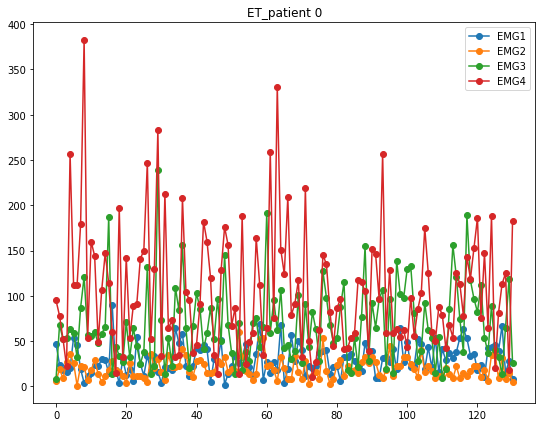

In [133]:
fig, ax = plt.subplots(figsize=[9, 7])
ax.plot(et_patient_0[0,::500],marker='o', label='EMG1')
ax.plot(et_patient_0[1,::500],marker='o', label='EMG2')
ax.plot(et_patient_0[2,::500],marker='o', label='EMG3')
ax.plot(et_patient_0[3,::500],marker='o', label='EMG4')
plt.title('ET_patient 0')
plt.legend()
plt.show()


In [135]:
conrtol_patient_0 = control_patients[0]

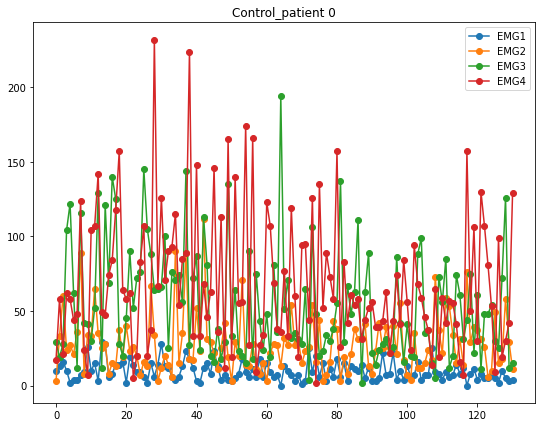

In [136]:
fig, ax = plt.subplots(figsize=[9, 7])
ax.plot(conrtol_patient_0 [0,::500],marker='o', label='EMG1')
ax.plot(conrtol_patient_0 [1,::500],marker='o', label='EMG2')
ax.plot(conrtol_patient_0 [2,::500],marker='o', label='EMG3')
ax.plot(conrtol_patient_0 [3,::500],marker='o', label='EMG4')
plt.title('Control_patient 0')
plt.legend()
plt.show()

## Trees on the new data!

In [9]:
data_v = np.genfromtxt('../CNN/data_cnn_vitr.csv', delimiter=',', dtype=None)
y = data_v[:,0]
X = np.array(data_v[:,1:])

In [10]:
X.shape

(41, 24)

In [16]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

TypeError: evaluate_model() missing 2 required positional arguments: 'X' and 'y'

In [18]:
Av_coefficients = [1.48,-2.09,0.16,1.02,-2.02,2.24,-0.05,0.04,1.28,-1.23,0.83,1.29, 2.91,-0.06,0.37,-0.89,0.60,-2.55,0.38,-0.69,1.039,1.21,0.49,0.39]
Bv_coefficients = [1.35,-2.00,-1.37,1.54,1.35,4.26,-0.25,0.99,0.34,-0.34,3.06,5.01, 3.20,-0.51,-2.86,0.39,-1.82,2.08,-2.10,1.76,-1.59,2.18,1.16,2.59]
Сv_coefficients = [1.45,1.34,-1.03,-0.37,0.97,1.80,-0.83,0.59,-0.43,1.00,1.72,-0.75, 2.81,-0.14,-1.87,-1.07,1.35,-0.18,-0.25,0.00,1.32,-1.33,1.16,2.22]
Dv_coefficients = [0.19,0.35,0.89,1.79,0.23,-0.36,0.15,0.84,1.11,0.15,-0.32,1.66, 0.44,1.34,0.46,-0.25,-0.24,0.08,-1.25,0.88,1.52,0.38,0.03,-0.95]


In [19]:
X_w = X

In [21]:
coef_v = np.vstack([Av_coefficients,Bv_coefficients,Сv_coefficients, Dv_coefficients])
X = np.matmul(X,np.transpose(coef_v))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 24 is different from 4)

In [28]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

TypeError: evaluate_model() missing 2 required positional arguments: 'X' and 'y'

In [ ]:
# combined

In [4]:
data = np.genfromtxt('../CNN/data_cnn.csv', delimiter=',', dtype=None)
labels = data[:,0]
features = data[:,1:]
data_v = np.genfromtxt('../CNN/data_cnn_vitr.csv', delimiter=',', dtype=None)
labels_v = data_v[:,0]
features_v = np.array(data_v[:,1:])

In [42]:
A_coefficients = [1.64,2.49,1.34,0.44,0.45,0.29,1.47,0.26,0.48,2.10,0.08,2.51, -1.14,0.90,1.79,0.83,-0.84,0.85,1.31,1.65,0.76,2.15,
0.58,2.09]
B_coefficients = [3.31,-1.99,1.76,1.15,-1.03,0.96,1.78,-1.87,0.59,-2.88,-0.31,-2.56, -3.34,-0.58,0.16,-0.40,1.66,-0.25,0.60,-0.12,-0.48,1.89,3.56,5.30]
С_coefficients = [0.38, -0.46,-1.31,1.30,0.86,-0.98,0.77,0.47, -0.29,-0.00,-0.44,-2.45, 0.47,0.06,-0.13,-1.24,0.01,3.27,0.47,0.21,-0.48,-0.03,1.00,3.06]
D_coefficients = [-0.07,1.13,-0.09,-0.27,0.95, 1.47,1.25,-0.08,1.14,1.13,-1.25,1.93, -1.43,1.49,0.54,1.16,-0.02,0.08,3.72,1.67,0.46,1.07,0.83,1.37]

In [44]:
coef = np.vstack([A_coefficients,B_coefficients,С_coefficients, D_coefficients])

In [45]:
features_v_abcd = np.matmul(features_v,np.transpose(coef_v))
features_abcd = np.dot(features,np.transpose(coef))

In [46]:
X=features_v_abcd + features_abcd
y=labels_v

In [48]:
X_2 = []
y_2 = []
for i in range(len(X)):
    if y[i]==0:
        X_2.append(X[i,:2])
        y_2.append(0)
    if y[i]==1:
        X_2.append(X[i,:2])
        y_2.append(1)

In [50]:
print(np.array(X_2).shape)

(28, 2)


>10 0.821 (0.036)
>50 0.857 (0.000)
>100 0.857 (0.000)
>500 0.857 (0.000)
>1000 0.857 (0.000)


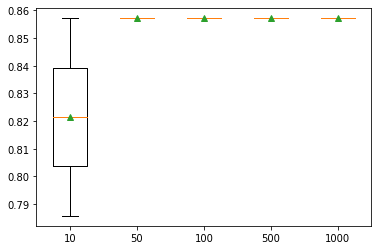

In [51]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, np.array(X_2), y_2)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.536 (0.179)
>50 0.585 (0.175)
>100 0.585 (0.188)
>500 0.585 (0.178)
>1000 0.583 (0.166)
>5000 0.575 (0.180)


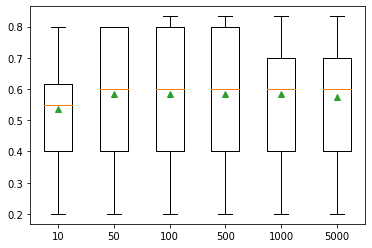

In [32]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [36]:
X.shape

(41, 4)

In [37]:
coef_v.shape

(4, 24)

In [38]:
features_v.shape

(41, 24)

### Tests 01.02.2023 feature dimensions PD vs Control

In [17]:
data_v = np.genfromtxt('../CNN/data_cnn_vitr.csv', delimiter=',', dtype=None)
labels_v = data_v[:,0]
features_v = np.array(data_v[:,1:])
data = np.genfromtxt('../CNN/data_cnn.csv', delimiter=',', dtype=None)
labels = data[:,0]
features = data[:,1:]

In [18]:
Av_coefficients = [1.48,-2.09,0.16,1.02,-2.02,2.24,-0.05,0.04,1.28,-1.23,0.83,1.29, 2.91,-0.06,0.37,-0.89,0.60,-2.55,0.38,-0.69,1.039,1.21,0.49,0.39]
Bv_coefficients = [1.35,-2.00,-1.37,1.54,1.35,4.26,-0.25,0.99,0.34,-0.34,3.06,5.01, 3.20,-0.51,-2.86,0.39,-1.82,2.08,-2.10,1.76,-1.59,2.18,1.16,2.59]
Сv_coefficients = [1.45,1.34,-1.03,-0.37,0.97,1.80,-0.83,0.59,-0.43,1.00,1.72,-0.75, 2.81,-0.14,-1.87,-1.07,1.35,-0.18,-0.25,0.00,1.32,-1.33,1.16,2.22]
Dv_coefficients = [0.19,0.35,0.89,1.79,0.23,-0.36,0.15,0.84,1.11,0.15,-0.32,1.66, 0.44,1.34,0.46,-0.25,-0.24,0.08,-1.25,0.88,1.52,0.38,0.03,-0.95]

In [19]:
A_coefficients = [1.64,2.49,1.34,0.44,0.45,0.29,1.47,0.26,0.48,2.10,0.08,2.51, -1.14,0.90,1.79,0.83,-0.84,0.85,1.31,1.65,0.76,2.15,
0.58,2.09]
B_coefficients = [3.31,-1.99,1.76,1.15,-1.03,0.96,1.78,-1.87,0.59,-2.88,-0.31,-2.56, -3.34,-0.58,0.16,-0.40,1.66,-0.25,0.60,-0.12,-0.48,1.89,3.56,5.30]
С_coefficients = [0.38, -0.46,-1.31,1.30,0.86,-0.98,0.77,0.47, -0.29,-0.00,-0.44,-2.45, 0.47,0.06,-0.13,-1.24,0.01,3.27,0.47,0.21,-0.48,-0.03,1.00,3.06]
D_coefficients = [-0.07,1.13,-0.09,-0.27,0.95, 1.47,1.25,-0.08,1.14,1.13,-1.25,1.93, -1.43,1.49,0.54,1.16,-0.02,0.08,3.72,1.67,0.46,1.07,0.83,1.37]

In [20]:
coef_v = np.vstack([Av_coefficients,Bv_coefficients,Сv_coefficients, Dv_coefficients])
coef = np.vstack([A_coefficients,B_coefficients,С_coefficients, D_coefficients])

In [21]:
features_v.shape

(41, 24)

In [22]:
ET_to_remove = labels_v==2.

In [23]:
labels_v

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2.])

In [24]:
features_v_a = features_v * Av_coefficients
features_v_b = features_v * Bv_coefficients
features_a = features * A_coefficients
features_b = features * B_coefficients

In [55]:
X=np.hstack([np.hstack([features_v_a, features_v_b]), np.hstack([features_a, features_b])])

In [45]:
X = np.hstack([features_a, features_b])

In [56]:
X.shape
#Xpd_control.shape

(41, 96)

In [57]:
ypd_control = np.zeros(41-np.sum(ET_to_remove))
for i, to_rem in enumerate(ET_to_remove):
    if not  to_rem:
        ypd_control[i]=labels_v[i]

In [58]:
Xpd_control = np.zeros((41-np.sum(ET_to_remove), 96))
for i, to_rem in enumerate(ET_to_remove):
    if not  to_rem:
        Xpd_control[i,:]=X[i,:]


In [59]:
Xpd_control.shape

(28, 96)

In [60]:
y = labels_v

In [122]:
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [1, 2, 5, 7, 10, 25, 50, 100, 500]
	for n in trees:
		models[str(n)] = XGBClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y, random_state):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=200, random_state=random_state)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>1 0.621 (0.249)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>2 0.738 (0.254)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>5 0.761 (0.240)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>7 0.804 (0.229)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>10 0.817 (0.212)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>25 0.837 (0.187)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>50 0.839 (0.185)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>100 0.839 (0.185)


C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\KHOKHLOVAM\Documents\projects\kotelnikov\.venv\lib\site-packages\sklearn\model_selectio

>500 0.839 (0.185)


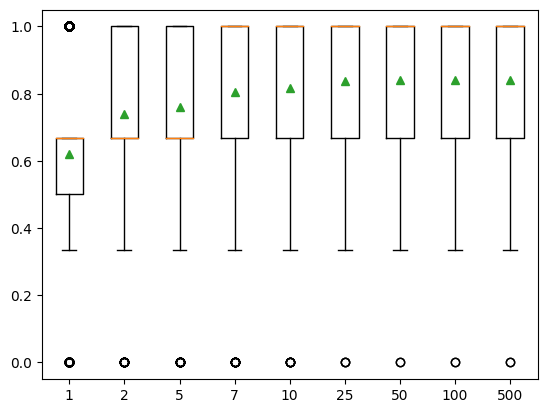

In [62]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, Xpd_control, ypd_control,0)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [99]:
ypd_control

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [97]:
print(features_v_b==features_v_b)

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True 

### Tests 01.02.2023 feature dimensions  ET & Control

In [64]:
data_v = np.genfromtxt('../CNN/data_cnn_vitr.csv', delimiter=',', dtype=None)
labels_v = data_v[:,0]
features_v = np.array(data_v[:,1:])
data = np.genfromtxt('../CNN/data_cnn.csv', delimiter=',', dtype=None)
labels = data[:,0]
features = data[:,1:]

In [65]:
Av_coefficients = [1.48,-2.09,0.16,1.02,-2.02,2.24,-0.05,0.04,1.28,-1.23,0.83,1.29, 2.91,-0.06,0.37,-0.89,0.60,-2.55,0.38,-0.69,1.039,1.21,0.49,0.39]
Bv_coefficients = [1.35,-2.00,-1.37,1.54,1.35,4.26,-0.25,0.99,0.34,-0.34,3.06,5.01, 3.20,-0.51,-2.86,0.39,-1.82,2.08,-2.10,1.76,-1.59,2.18,1.16,2.59]
Сv_coefficients = [1.45,1.34,-1.03,-0.37,0.97,1.80,-0.83,0.59,-0.43,1.00,1.72,-0.75, 2.81,-0.14,-1.87,-1.07,1.35,-0.18,-0.25,0.00,1.32,-1.33,1.16,2.22]
Dv_coefficients = [0.19,0.35,0.89,1.79,0.23,-0.36,0.15,0.84,1.11,0.15,-0.32,1.66, 0.44,1.34,0.46,-0.25,-0.24,0.08,-1.25,0.88,1.52,0.38,0.03,-0.95]
A_coefficients = [1.64,2.49,1.34,0.44,0.45,0.29,1.47,0.26,0.48,2.10,0.08,2.51, -1.14,0.90,1.79,0.83,-0.84,0.85,1.31,1.65,0.76,2.15,
0.58,2.09]
B_coefficients = [3.31,-1.99,1.76,1.15,-1.03,0.96,1.78,-1.87,0.59,-2.88,-0.31,-2.56, -3.34,-0.58,0.16,-0.40,1.66,-0.25,0.60,-0.12,-0.48,1.89,3.56,5.30]
С_coefficients = [0.38, -0.46,-1.31,1.30,0.86,-0.98,0.77,0.47, -0.29,-0.00,-0.44,-2.45, 0.47,0.06,-0.13,-1.24,0.01,3.27,0.47,0.21,-0.48,-0.03,1.00,3.06]
D_coefficients = [-0.07,1.13,-0.09,-0.27,0.95, 1.47,1.25,-0.08,1.14,1.13,-1.25,1.93, -1.43,1.49,0.54,1.16,-0.02,0.08,3.72,1.67,0.46,1.07,0.83,1.37]

In [66]:
coef_v = np.vstack([Av_coefficients,Bv_coefficients,Сv_coefficients, Dv_coefficients])
coef = np.vstack([A_coefficients,B_coefficients,С_coefficients, D_coefficients])

In [110]:
X=np.hstack([np.hstack([features_v_a, features_v_b]), np.hstack([features_a, features_b])])

In [101]:
X=np.hstack([features_a, features_b])

In [111]:
PD_to_remove = labels_v==1

In [112]:
labels_v

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2.])

In [113]:
PD_to_remove

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [116]:
j=0
Xet_control = np.zeros((41-np.sum(PD_to_remove), 96))
for i, to_rem in enumerate(PD_to_remove):
    if not  to_rem:
        Xet_control[j,:]=X[i,:]
        j+=1


In [117]:
j=0
yet_control = np.zeros(41-np.sum(PD_to_remove))
for i, to_rem in enumerate(PD_to_remove):
    if not  to_rem:
        yet_control[j]=labels_v[i]        
        if yet_control[j] == 2:
            yet_control[j] = 1
        j+=1
            

In [118]:
print(Xet_control.shape, yet_control.shape)

(21, 96) (21,)


In [119]:
Xet_control

array([[ 0.34661098, -0.04078924,  1.19752532, ...,  0.35992617,
         4.27633892, 11.45186335],
       [ 0.43947202, -0.08007816,  1.15711029, ...,  0.15101549,
         3.54272598, 16.20783334],
       [ 0.43558831, -0.06834681,  1.20342715, ...,  0.37118168,
         5.05544309, 10.48886606],
       ...,
       [ 0.47000591, -0.11443527,  1.03900655, ...,  0.27416818,
         3.5877781 , 12.22037289],
       [ 0.21705881, -0.        ,  1.04758114, ...,  0.22052389,
         4.62108395, 10.28090543],
       [ 0.47599286, -0.06504959,  1.20844918, ...,  0.30830225,
         4.09027078, 11.2767557 ]])

>1 0.383 (0.300)
>2 0.443 (0.280)
>5 0.446 (0.290)
>7 0.435 (0.285)
>10 0.448 (0.282)
>25 0.458 (0.300)
>50 0.456 (0.294)
>100 0.456 (0.294)
>500 0.456 (0.294)


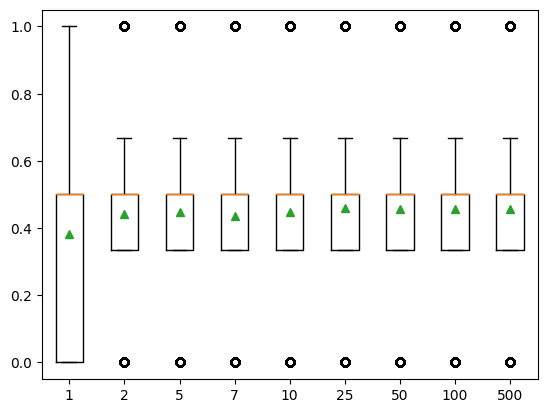

In [123]:
# %%capture --no-display
import warnings
warnings.filterwarnings('ignore')
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, Xet_control, yet_control,1)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()